Department of Physics, University of Pisa (AA 2020-2021)

### Multimessenger Physics Laboratory



# GRAVITATIONAL WAVES ANALYSIS: GW150914
#### (Cozzolongo Giovanni)
This script is structured with classes and modules as follows:

<ul>
<li>ASD</li>
    <ul>
    <li>all_asd</li>
    <li>asd_evolution_single</li>
    <li>asd_evolution_total</li>
    </ul>
<li>template_based_research</li>
    <ul>
    <li>raw_and_quality</li>
    <li>matched_filter</li>
    </ul>
<li>bilby</li>
    <ul>
    <li>bayesian_inference</li>
    <li>chirp_mass</li>
    <li>masses</li>
</ul>

The aim of each class is write at the top of each of cell, wich contain the class itself. More details in the script's comments.

## Python's modules and directories
The following cell imports modules and define the directories.

In [1]:
# Import the modules
import os
import sys
import pylab
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from gwpy.plot import Plot
from scipy.signal import get_window
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.filter import sigma
from pycbc.filter import resample_to_delta_t, highpass
from __future__ import division, print_function
import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
from gwpy.timeseries import TimeSeries

# Define the directories
work_dir = os.getcwd()
main_dir =os.path.dirname(work_dir)
data_dir = os.path.join(main_dir,"data")
results_dir = os.path.join(main_dir,"results")

## Class: ASD
The following cell analyse the Amplitude Spectral Density (ASD).\
In particular module all_asd make a graph with the ASD of all detectors. An interval of one hour centered around the time of the event were cosidered.\
In the other modules, the frequency intervals of 10 Hz from 10 Hz to 1400 Hz are considered. For each of these, the ASD was averaged in 4-second intervals from 30 minutes before to 30 minutes after the time of the event. With The module asd_evolution_single you can chose of wihch frequency range you want to see the time evolution. While with the module asd_evolution_total, you can see them all or and you can also decide if replace the elements of the matrix with the difference between the elements themselves and their time average.

**__init__**\
*INPUT*: event name.


**all_asd**\
*INPUT*: nothing.

**asd_evolution_single**\
*INPUT*: interferometer to use, minimal frequency and maximum frequency to consider, frequency and time width range.

**asd_evolution_total**\
*INPUT*: interferometer to use, frequency and time width range.

In [2]:
class ASD():
    
    def __init__(self, ev_name):
        
        self.ev_name = ev_name
    
    ## MODULES ##
    def all_asd(self):
        
        # Select a time interval around the event
        dt_win=3600*0.5
        ev_gps = event_gps(self.ev_name)
        ev_t0_min = ev_gps-dt_win
        ev_t0_max = ev_gps+dt_win
        print("Get data for %s (H1,L1) GPS: %.2f - %.2f" % (self.ev_name,ev_t0_min,ev_t0_max))
        
        # Get Hanford data
        hdata = TimeSeries.fetch_open_data('H1', ev_t0_min, ev_t0_max, cache=True)
        
        # Find ASD
        hasd = hdata.asd(fftlength=4, method="median")
        
        # Get Livingston data
        ldata = TimeSeries.fetch_open_data('L1', ev_t0_min, ev_t0_max, cache=True)
        
        # Find ASD
        lasd = ldata.asd(fftlength=4, method="median")

        # Plot using standard colours
        plt.rcParams["font.size"] = 11
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(hasd, label='LIGO-Hanford', color='gwpy:ligo-hanford')
        ax.plot(lasd, label='LIGO-Livingston', color='gwpy:ligo-livingston')
        ax.set_xlabel(r'Frequency [Hz]', fontsize = 11)
        ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]', fontsize = 11)
        ax.legend()
        ax.set_xlim(10, 1400)
        ax.set_ylim(2e-24, 1e-20)
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.savefig(os.path.join(results_dir, "asd_all_2.pdf"), bbox_inches='tight')
        plt.show()
        
    def asd_evolution_single(self, ev_ifo, f_min, f_max, Df, Dt):
        
        # Select a time interval around the event.
        dt_win=3600*0.5
        ev_gps = event_gps(self.ev_name)
        ev_t0_min = ev_gps-dt_win
        ev_t0_max = ev_gps+dt_win
        print("Get data for %s (%s) GPS: %.2f - %.2f" % (self.ev_name,ev_ifo,ev_t0_min,ev_t0_max))
        
        # Fetch the data. Use cache=True to keep the data in the cache memory
        data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
        
        # Make a list with ASD mean values at different times
        asd_list = []
        df = 0.25                     # Frequency step
        dt = int(Dt/0.000244140625)   # Time step
        for i in range(int(3600/Dt)):
            asd = data[i*dt:(i+Dt)*dt].asd(fftlength=4, method="median")
            asd_list.append(np.asarray(asd[int(f_min/df):int(f_max/df)]).mean())
        
        # Find mean and standard deviation of ASD
        mean = np.asarray(asd_list).mean()
        std = np.asarray(asd_list).std()
        
        t_0 = 1186740061.5
        x_points = np.linspace(t_0, t_0+Dt, len(asd_list))
        
        # Plot
        plt.rcParams["font.size"] = 13
        plt.figure(figsize=[15, 3])
        plt.axhline(y=mean, label="mean", color='tab:red', linestyle='--')
        plt.axhline(y=mean-1*std, label="threshold", color='tab:green', linestyle='--')
        plt.axhline(y=mean+1*std, label="threshold", color='tab:green', linestyle='--')
        plt.plot(x_points, asd_list, color='black', marker='.')
        plt.xlabel('Time [s]')
        plt.ylabel('ASD mean')
        plt.savefig(os.path.join(results_dir, "signal_%f.pdf" %f_min), bbox_inches='tight')
        plt.show()
        
    def asd_evolution_total(self, ev_ifo, Df, Dt):
        
        # Select a time interval around the event
        dt_win=3600*0.5
        ev_gps = event_gps(self.ev_name)
        ev_t0_min = ev_gps-dt_win
        ev_t0_max = ev_gps+dt_win
        print("Get data for %s (%s) GPS: %.2f - %.2f" % (self.ev_name,ev_ifo,ev_t0_min,ev_t0_max))
        
        # Fetch the data. Use cache=True to keep the data in the cache memory
        data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
        
        # Create a matrix with ASD value (time as raws and frequency as columns)
        asd_matrix = np.zeros((int(3600/Dt),1400))
        df = 0.25                     # Frequency step
        dt = int(Dt/0.000244140625)   # Time step
        for i in range(0,int(3600/Dt)):
            asd = data[i*dt:(i+Dt)*dt].asd(fftlength=4, method="median")
            for f_min in range(0,1400):
                asd_matrix[i][f_min] = np.asarray(asd[int(f_min/df):int((f_min+10)/df)]).mean()
        asd_matrix = asd_matrix.transpose()
        color = LogNorm()
        
        # Uncomment if, for each frequency range, you want that replace the elements of the matrix with
        # the difference between the elements themselves and their time average
        '''
        for f_min in range(len(asd_matrix)-1):
            summ = 0
            mean = 0
            for i in range(len(asd_matrix[0])-1):
                summ = summ + asd_matrix[f_min][i]
            mean = summ/(3600/4)
            for i in range(len(asd_matrix[0])):
                asd_matrix[f_min][i] = asd_matrix[f_min][i]-mean
                
        color = norm
        '''
        
        # Plot
        plt.rcParams["font.size"] = 13
        plt.figure(figsize = (40,10))
        ax1 = plt.subplot(221)
        c = ax1.imshow(asd_matrix,interpolation="None",cmap="jet",aspect="auto",norm=color)
        plt.colorbar(c)
        plt.xlabel('Time [4 seconds]')
        plt.ylabel('Frequency [Hz]')
        plt.ylim(10, 1400)
        plt.savefig(os.path.join(results_dir, "ASD_evolution.pdf"), bbox_inches='tight')

## Class: template_based_search
The following cell is useful for quicklook and matched filter.
In particular, the module **quicklook** makes a plot of the strain data and their quality.\
While the module **matched_filter** apply a template based research to find the matched filter. As output, it shows the signal to noise ratio (SNR) vs time, the matched filter and strain data vs time and the two Q transform (one for the original signal data and the other for subtracted signal data).

In [8]:
class template_based_search():
    
    def __init__(self, ev_name, ev_ifo, dt_win):   
        
        # Select a time interval around the event
        self.dt_win = dt_win
        self.ev_ifo = ev_ifo
        self.ev_gps = event_gps(ev_name)
        self.ev_t0_min = self.ev_gps-self.dt_win
        self.ev_t0_max = self.ev_gps+self.dt_win
        print("Get data foself.r %s (%s) GPS: %.2f - %.2f" % (ev_name,self.ev_ifo,self.ev_t0_min,self.ev_t0_max))
        
        #fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
        self.data = TimeSeries.fetch_open_data(ev_ifo,self.ev_t0_min,self.ev_t0_max,cache=True)
    
    ## MODULES ##
    def quicklook(self, f_min, f_max, notch):
        
        # Apply a high-frequency bandpass
        if (f_min != '' and f_max != ''):
            data = self.data.bandpass(f_min,f_max)
            
        # Apply a notch filter in order to remove the power line at 60 Hz
        if (notch != ''):
            data = data.notch(notch)
        
        # Get the segments in a larger time window
        segments = DataQualityFlag.fetch_open_data(self.ev_ifo+"_DATA",self.ev_t0_min-self.dt_win,self.ev_t0_max+self.dt_win)
        
        # Plot raw data   
        plot_data=data.plot()
        plot_data.show()
        ax = plot_data.gca()
        
        # Zoom around the event
        ax.set_xlim(self.ev_gps-self.dt_win*0.1,self.ev_gps+self.dt_win*0.1)
        plot_data.refresh()

        # Quality plot
        plot = segments.plot()
    
    def matched_filter(self, mass_0):

        # Convert the data from gwpy to pyCBC format
        strain = self.data.to_pycbc()

        # Remove the frequencies below 15 Hz and downsample the data to 2048Hz
        strain = highpass(strain, 15.0)
        strain = resample_to_delta_t(strain, 1.0/2048)

        # Remove 2 seconds of data from both the beginning and end, to remove the ringing artifacts
        conditioned = strain.crop(2, 2)
        
        psd = conditioned.psd(4)
        psd = interpolate(psd, conditioned.delta_f)
        psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                          low_frequency_cutoff=15)
        
        # Matched filter search
        snrp_max = 0     # This quantity will be used to memorize the pick value of the SNR with the higher pick
        for i in range(-30, 30):
            mass_guess_1 = mass_0 + i*0.5 # Solar masses
            
            # I use the symmetry of the two masses to avoid repeating the cycles twice
            if(i < 0):
                j_max = 0
            else:
                j_max = 30
                
            for j in range(-30,j_max):
                mass_guess_2 = mass_0 + j*0.5 # Solar masses
                
                # Create a waveform
                hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                     mass1=mass_guess_1,
                                     mass2=mass_guess_2,
                                     delta_t=conditioned.delta_t,
                                     f_lower=20)

                # Resize the vector to match our data
                hp.resize(len(conditioned))
            
                # Use the start time to  shift the waveforms into position
                template = hp.cyclic_time_shift(hp.start_time)

                # Apply a low frequency cut-off
                snr = matched_filter(template, conditioned,
                                     psd=psd, low_frequency_cutoff=20)
                
                # Remove time corrupted by the template filter and the psd filter
                snr = snr.crop(4 + 4, 4)

                #Take the magnitude of snr
                peak = abs(snr).numpy().argmax()
                snrp = snr[peak]

                # Check if the pick of the new SNR is higher than snrp_max
                if (abs(snrp) > abs(snrp_max)):
                    snrp_max = snrp
                    peak_max = peak
                    snr_max = snr
                    template_max = template
                    mass1_max = mass_guess_1
                    mass2_max = mass_guess_2  

        # Shift the template to the peak time
        time = snr.sample_times[peak_max]
        dt = time - conditioned.start_time
        aligned = template_max.cyclic_time_shift(dt)

        # Scale the template so that it would have SNR 1 in this data
        aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
            
        # Scale the template amplitude and phase to the peak value
        aligned = (aligned.to_frequencyseries() * snrp_max).to_timeseries()
        aligned.start_time = conditioned.start_time

        # Whiten (i.e. normalize the signal to the PSD) both the template and the data
        white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
        white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

        # Apply high and low pass filter
        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

        # Select the time around the merger
        white_data = white_data.time_slice(self.ev_gps-.2, self.ev_gps+.1)
        white_template = white_template.time_slice(self.ev_gps-.2, self.ev_gps+.1)

        #Take the time of the pick with the maximum SNR
        time = snr_max.sample_times[peak_max]
        print("We found a signal at {}s with SNR {}".format(time, 
                                                                abs(snrp_max)))
        print("The masses are %f and %f solar masses." %(mass1_max,mass2_max))
        plt.rcParams["font.size"] = 13
        plt.figure(figsize=[4, 2.3])
        ax = plt.axes()
        if(self.ev_ifo == 'H1'):
            color_ifo = 'gwpy:ligo-hanford'
        elif(self.ev_ifo == 'L1'):
            color_ifo = 'gwpy:ligo-livingston'
        else:
            color_ifo = 'gwpy:virgo'
            
        # Plot Signal-to-noise vs Time
        plt.plot(snr_max.sample_times, abs(snr_max), color=color_ifo)
        ax.set_xlabel('Time (s)', fontsize = 13)
        ax.set_ylabel('Signal-to-noise', fontsize = 13)
        plt.xlim(self.ev_gps - 0.2, self.ev_gps + 0.09)
        ax.tick_params(labelbottom=False) 
        ax.set(xlabel=None)  # remove the axis label
        ax.yaxis.tick_right()
        #ax.tick_params(labelleft=False) 
        ax.set(ylabel=None)  # remove the axis label
        plt.savefig(os.path.join(results_dir, "SNR_%s.pdf" %self.ev_ifo), bbox_inches='tight')
        pylab.show()

        # Plot Strain vs Time
        plt.rcParams["font.size"] = 13
        plt.figure(figsize=[4, 2.3])
        ax = plt.axes()
        plt.plot(white_data.sample_times, white_data, label="Data", color=color_ifo, alpha=0.3)
        plt.plot(white_template.sample_times, white_template, label="Template", color=color_ifo)
        ax.set_xlabel('Time (s)', fontsize = 13)
        ax.set_ylabel('Strain ($10^{-23}$)', fontsize = 13)
        plt.xlim(self.ev_gps - 0.2, self.ev_gps + 0.09)
        plt.legend()
        ax.tick_params(labelbottom=False) 
        ax.set(xlabel=None)  # remove the axis label
        ax.yaxis.tick_right()
        #ax.tick_params(labelleft=False) 
        ax.set(ylabel=None)  # remove the axis label
        plt.savefig(os.path.join(results_dir, "matched_filter_%s.pdf" %self.ev_ifo), bbox_inches='tight')
        pylab.show()

        # Make the Q transform
        # Plot the original data and the subtracted signal data
        subtracted = conditioned - aligned
        flag = 0     # Flag to change the saved file name
        for data in [conditioned,
                            subtracted,]:

            t, f, p = data.whiten(4, 4).qtransform(.001,
                                                   logfsteps=100,
                                                   qrange=(8, 8),
                                                   frange=(20, 512))
            
            plt.rcParams["font.size"] = 13
            plt.figure(figsize=[4, 2.3])
            ax = plt.axes()
            plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
            ax.set_xlabel('Time (s)', fontsize = 13, loc='left')
            ax.set_ylabel('Frequency (Hz)', fontsize = 13)
            plt.yscale('log')
            plt.xlim(self.ev_gps - 0.2, self.ev_gps + 0.09)
            ax.tick_params(labelbottom=False) 
            ax.set(xlabel=None)  # remove the axis label
            ax.yaxis.tick_right()
            ax.tick_params(labelleft=False) 
            ax.set(ylabel=None)  # remove the axis label
            
            # Save the figures with different names
            if (flag == 0):
                pylab.savefig(os.path.join(results_dir, "Q_original_%s" %self.ev_ifo), bbox_inches='tight')
                flag = 1
            else:
                plt.savefig(os.path.join(results_dir, "Q_subtracted_%s" %self.ev_ifo), bbox_inches='tight')
            pylab.show()

## Class: bilby
The following cell estimates the non-spinning parameters of the binary black hole system using commonly used prior distributions.\
Indeed the module **bayesian_inference** create a prior fixing everything except the chirp mass, the mass ratio, the phase and the geocent_time (time of merge) to fixed values. The it creates a likelihood and runs the analysis.\
The module **credible_interval_mass** and **corner_masses** use the result of the previous module. In particular, **credible_interval_mass** plot the chirp, primary and secondary mass in a histogram adding a region to indicate the 90\% C.I.. Finally it prints the Bayes factor for quantifies the probability that the analyzed segment constains a binary black hole signal compared to just containing noise.\
While **correlation_masses** make a corner plot for the masses of the two objects.

In [4]:
class bilby():

    def __init__(self, ev_name, ev_ifo):   
            
        # Select a time interval around the event
        self.ev_ifo = ev_ifo
        self.ev_gps = event_gps(ev_name)
        
    def bayesian_inference(self):    
        time_of_event = 1126259462.4
        
        import bilby
        from bilby.core.prior import Uniform
        from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
        from gwpy.timeseries import TimeSeries

        # Create two "empty" interferometers. These are empty in the sense that they don't have any strain data.
        #But, they know about the orientation and location of their respective namesakes.
        H1 = bilby.gw.detector.get_empty_interferometer("H1")
        L1 = bilby.gw.detector.get_empty_interferometer("L1")

        # Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
        post_trigger_duration = 2
        duration = 4
        analysis_start = time_of_event + post_trigger_duration - duration

        # Use gwpy to fetch the open data
        H1_analysis_data = TimeSeries.fetch_open_data(
            "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

        L1_analysis_data = TimeSeries.fetch_open_data(
            "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)
        
        H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
        L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)
        
        psd_duration = duration * 32
        psd_start_time = analysis_start - psd_duration

        H1_psd_data = TimeSeries.fetch_open_data(
            "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

        L1_psd_data = TimeSeries.fetch_open_data(
            "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

        psd_alpha = 2 * H1.strain_data.roll_off / duration
        H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
        L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

        H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
        L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)
        
        # Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values.
        prior = bilby.core.prior.PriorDict()
        prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
        prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
        prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
        prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
        prior['a_1'] =  0.0
        prior['a_2'] =  0.0
        prior['tilt_1'] =  0.0
        prior['tilt_2'] =  0.0
        prior['phi_12'] =  0.0
        prior['phi_jl'] =  0.0
        prior['dec'] =  -1.2232
        prior['ra'] =  2.19432
        prior['theta_jn'] =  1.89694
        prior['psi'] =  0.532268
        prior['luminosity_distance'] = 412.066

        # Put our the data created above into a list of intererometers
        interferometers = [H1, L1]

        # Create a dictionary of arguments which we pass into the LALSimulation waveform
        waveform_arguments = dict(
            waveform_approximant='SEOBNRv4_opt', reference_frequency=100., catch_waveform_errors=True)

        # Create a waveform_generator object. This wraps up some of the jobs of converting between parameters, etc.
        waveform_generator = bilby.gw.WaveformGenerator(
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            waveform_arguments=waveform_arguments,
            parameter_conversion=convert_to_lal_binary_black_hole_parameters)

        # Create the likelihood
        likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
            interferometers, waveform_generator, priors=prior,
            time_marginalization=True, phase_marginalization=True, distance_marginalization=False)
        
        result_short = bilby.run_sampler(
            likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
            conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
            sample="unif", nlive=1000, dlogz=3
        )
        
        # This quantity is usefull for the next modules
        return result_short
    
    # Find the chirp mass
    def credible_interval_mass(self):
        
        '''Chirp mass values'''
        Mc = result_short.posterior["chirp_mass"].values
        # Get the 90\% credible interval
        lower_bound = np.quantile(Mc, 0.05)
        upper_bound = np.quantile(Mc, 0.95)
        median = np.quantile(Mc, 0.5)
        print("Mc = {} with a 90% C.I. = {} -> {}".format(median, lower_bound, upper_bound))
        # Plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.
        fig, ax = plt.subplots()
        ax.hist(result_short.posterior["chirp_mass"], bins=20)
        ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
        ax.axvline(median, color='C1')
        ax.set_xlabel("Chirp mass [$M_\odot$]")
        plt.savefig(os.path.join(results_dir, "chirp_mass.pdf"), bbox_inches='tight')
        plt.show()
        
        '''Primary mass'''
        M1 = result_short.posterior["mass_1_source"].values
        # Get the 90\% credible interval
        lower_bound = np.quantile(M1, 0.05)
        upper_bound = np.quantile(M1, 0.95)
        median = np.quantile(M1, 0.5)
        print("M1 = {} with a 90% C.I. = {} -> {}".format(median, lower_bound, upper_bound))
        # Plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.
        fig, ax = plt.subplots()
        ax.hist(result_short.posterior["mass_1_source"], bins=20)
        ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
        ax.axvline(median, color='C1')
        ax.set_xlabel("Primary mass [$M_\odot$]")
        plt.savefig(os.path.join(results_dir, "primary_mass.pdf"), bbox_inches='tight')
        plt.show()
        
        '''Secondary mass'''
        M2 = result_short.posterior["mass_2_source"].values
        # Get the 90\% credible interval
        lower_bound = np.quantile(M2, 0.05)
        upper_bound = np.quantile(M2, 0.95)
        median = np.quantile(M2, 0.5)
        print("M2 = {} with a 90% C.I. = {} -> {}".format(median, lower_bound, upper_bound))
        # Plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.
        fig, ax = plt.subplots()
        ax.hist(result_short.posterior["mass_2_source"], bins=20)
        ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
        ax.axvline(median, color='C1')
        ax.set_xlabel("Secondary mass [$M_\odot$]")
        plt.savefig(os.path.join(results_dir, "secondary_mass.pdf"), bbox_inches='tight')
        plt.show()
        
        # Print the Bayes factor for the signal vs. Gaussian noise
        print("ln Bayes factor = {} +/- {}".format(
            result_short.log_bayes_factor, result_short.log_evidence_err))
        
    def correlation_masses(self, mass_1, mass_2):
        # Plot the corner plots for the two masses
        plot = result_short.plot_corner(parameters=["mass_1_source", "mass_2_source"], prior=True)
        plot.savefig(os.path.join(results_dir, "masses.pdf"), bbox_inches='tight')

## Example
The following code shows example of inputs for all the modules of each classes.

Get data for GW150914 (H1,L1) GPS: 1126257662.40 - 1126261262.40


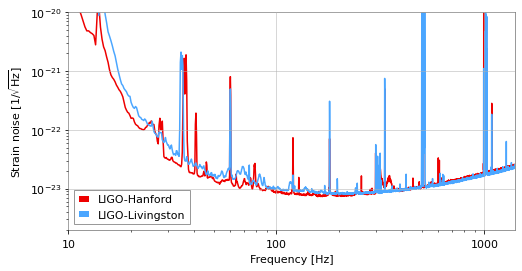

Get data for GW150914 (H1) GPS: 1126257662.40 - 1126261262.40


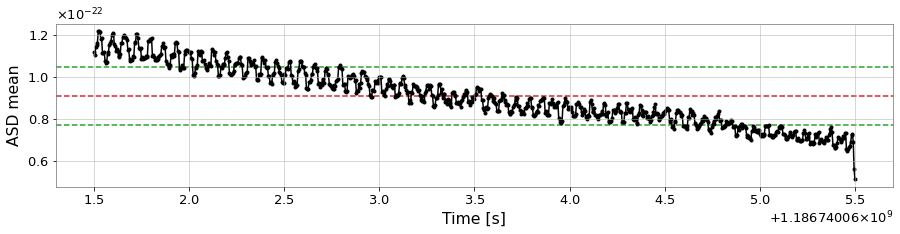

Get data for GW150914 (H1) GPS: 1126257662.40 - 1126261262.40


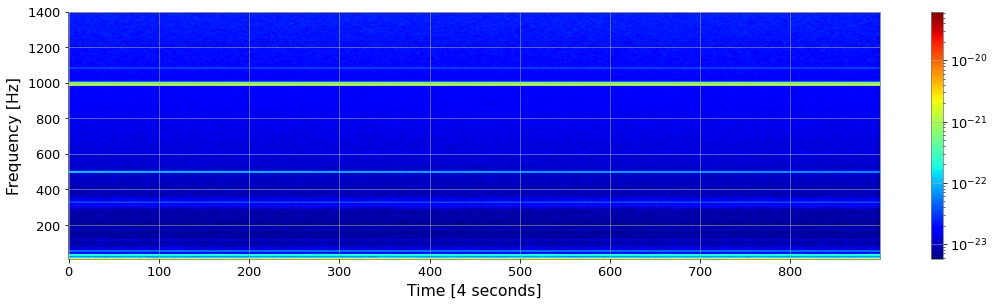

In [7]:
## ASD class ##
ASD_class = ASD('GW150914')
ASD_class.all_asd()
ASD_class.asd_evolution_single('H1',500,510,10,4)
ASD_class.asd_evolution_total('H1',10,4)

Get data foself.r GW150914 (H1) GPS: 1126259452.40 - 1126259472.40
We found a signal at 1126259462.4248047s with SNR 19.78706665386814
The masses are 39.500000 and 33.000000 solar masses.


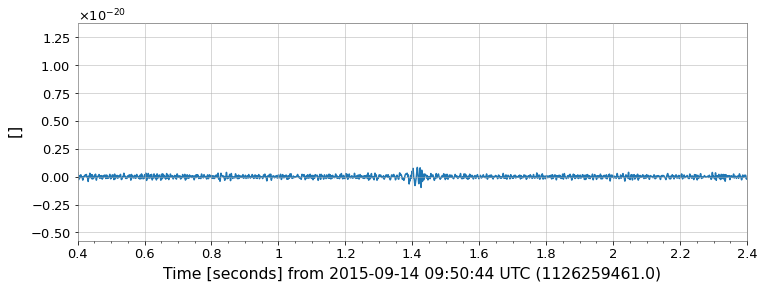

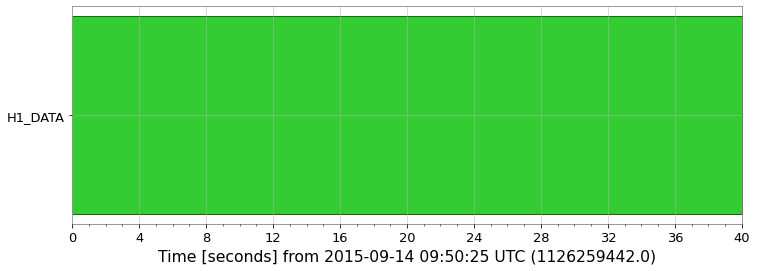

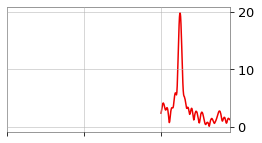

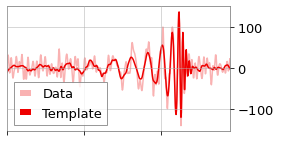

/opt/conda/lib/python3.8/site-packages/gwpy/plot/axes.py:282: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return super().pcolormesh(*args, **kwargs)


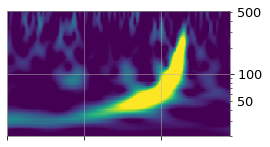

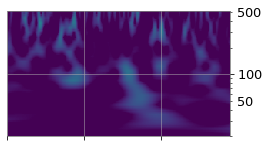

In [9]:
## template_based_search class ##
template_based_search_class = template_based_search('GW150914','H1',10)
template_based_search_class.quicklook(50,300,60)
template_based_search_class.matched_filter(30)

13:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:50 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
13:50 bilby INFO    : Using lal version 7.1.1
13:50 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.1;Id: 435541adf4bdf6f29f73af9808d618a4ec2759da;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:50 bilby INFO    : Using lalsimulation version 2.5.0
13:50 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v2.5.0;Id: 37f37be492dde660c8e91d62099e705514bd9243;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:50 bilby INFO    : Search parameters:
13:50 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5

0it [00:00, ?it/s]

13:50 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f2f5566bfa0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
13:50 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:50 bilby INFO    : Using dynesty version 1.0.1
13:50 bilby INFO    : Reading resume file short/GW150914_resum

1933it [00:00, 13523.90it/s, bound:0 nc:  1 ncall:7.1e+03 eff:27.4% logz-ratio=265.81+/-0.06 dlogz:2.997>3]

13:50 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
13:50 bilby INFO    : Writing 366 current samples to short/GW150914_samples.dat


1933it [00:03, 516.97it/s, bound:0 nc:  1 ncall:7.1e+03 eff:41.6% logz-ratio=267.69+/-0.10 dlogz:0.003>3]  



13:50 bilby INFO    : Sampling time: 0:05:36.064314
13:50 bilby INFO    : Reconstructing marginalised parameters.


100%|██████████| 2933/2933 [02:35<00:00, 18.83it/s]

13:53 bilby INFO    : Generating sky frame parameters.



100%|██████████| 2933/2933 [00:00<00:00, 3230.68it/s]


13:53 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 2933/2933 [02:41<00:00, 18.16it/s]


13:56 bilby INFO    : Summary of results:
nsamples: 2933
ln_noise_evidence: -17273.289
ln_evidence: -17005.600 +/-  0.098
ln_bayes_factor: 267.689 +/-  0.098



Mc = 31.212896808188386 with a 90% C.I. = 30.75832030387184 -> 31.74772085761419


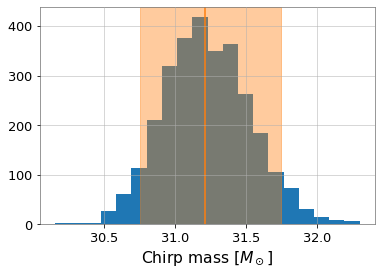

M1 = 34.3335233406297 with a 90% C.I. = 32.965547896383896 -> 37.154532790038566


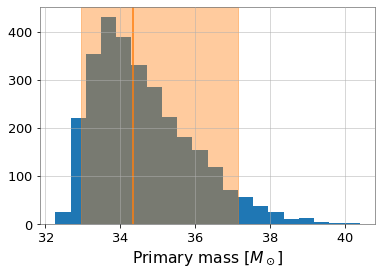

M2 = 31.765841842375004 with a 90% C.I. = 29.256471269912574 -> 33.04093824281178


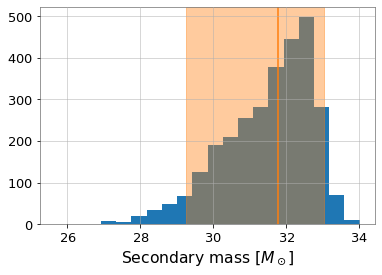

ln Bayes factor = 267.688683100986 +/- 0.09827797081314134


In [10]:
## bilby class ##
bilby_class = bilby('GW150914','H1')
result_short = bilby_class.bayesian_inference()
bilby_class.credible_interval_mass()
bilby_class.correlation_masses(33,39.5)